In [ ]:
#export
from local.imports import *
from local.test import *
from local.core import *
from local.layers import *
from local.data.pipeline import *
from local.data.source import *
from local.data.core import *
from local.data.external import *
from local.notebook.showdoc import show_doc
from local.optimizer import *
from local.learner import *

# Hyperparam schedule

> Callback and helper functions to schedule any hyper-parameter

## Synthetic data

We'll use the following for testing purposes (a basic linear regression problem):

In [ ]:
from torch.utils.data import TensorDataset

def synth_data(a=2, b=3, bs=16, n_trn=10, n_val=2):
    x_trn = torch.randn(bs*n_trn)
    y_trn = a*x_trn + b + 0.1*torch.randn(bs*n_trn)
    x_val = torch.randn(bs*n_val)
    y_val = a*x_val + b + 0.1*torch.randn(bs*n_val)
    train_ds = TensorDataset(x_trn, y_trn)
    valid_ds = TensorDataset(x_val, y_val)
    train_dl = TfmdDL(train_ds, bs=bs, shuffle=True)
    valid_dl = TfmdDL(valid_ds, bs=bs)
    return DataBunch(train_dl, valid_dl)

In [ ]:
class RegModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.a,self.b = nn.Parameter(torch.randn(1)),nn.Parameter(torch.randn(1))
    def forward(self, x): return x * self.a + self.b

## Annealing

In [ ]:
#export
def annealer(f):
    "Decorator to make `f` return itself partially applied."
    def _inner(start, end): return partial(f, start, end)
    return _inner

This is the decorator we will use for all of our scheduling functions, as it transforms a function taking `(start, end, pos)` to something taking `(start, end)` and return a function depending of `pos`.

In [ ]:
#export
@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no (start, end, pos): return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

sched_lin.__doc__ = "Linear schedule function from `start` to `end`"
sched_cos.__doc__ = "Cosine schedule function from `start` to `end`"
sched_no .__doc__ = "Constant schedule function with `start` value"
sched_exp.__doc__ = "Exponential schedule function from `start` to `end`"

In [ ]:
show_doc(sched_lin, name='sched_lin')

<h4 id="<code>sched_lin</code>" class="doc_header"><code>sched_lin</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>sched_lin</code>(**`start`**, **`end`**)

Linear schedule function from `start` to `end`

In [ ]:
sched = sched_lin(0, 2)
test_eq(L(map(sched, [0., 0.25, 0.5, 0.75, 1.])), [0., 0.5, 1., 1.5, 2.])

In [ ]:
show_doc(sched_cos, name='sched_cos')

<h4 id="<code>sched_cos</code>" class="doc_header"><code>sched_cos</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>sched_cos</code>(**`start`**, **`end`**)

Cosine schedule function from `start` to `end`

In [ ]:
sched = sched_cos(0, 2)
test_close(L(map(sched, [0., 0.25, 0.5, 0.75, 1.])), [0., 0.29289, 1., 1.70711, 2.])

In [ ]:
show_doc(sched_no, name='sched_no')

<h4 id="<code>sched_no</code>" class="doc_header"><code>sched_no</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>sched_no</code>(**`start`**, **`end`**)

Constant schedule function with `start` value

In [ ]:
sched = sched_no(0, 2)
test_close(L(map(sched, [0., 0.25, 0.5, 0.75, 1.])), [0., 0., 0., 0., 0.])

In [ ]:
show_doc(sched_exp, name='sched_exp')

<h4 id="<code>sched_exp</code>" class="doc_header"><code>sched_exp</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>sched_exp</code>(**`start`**, **`end`**)

Exponential schedule function from `start` to `end`

In [ ]:
sched = sched_exp(1, 2)
test_close(L(map(sched, [0., 0.25, 0.5, 0.75, 1.])), [1., 1.18921, 1.41421, 1.68179, 2.])

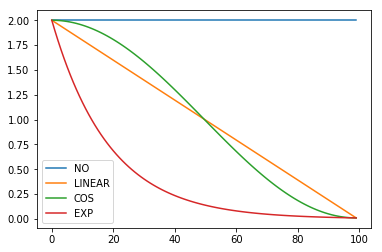

In [ ]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

In [ ]:
def sched_poly(start, end, power): 
    "Polynomial schedule (of `power`) function from `start` to `end`"
    def _inner(pos): return start + (end - start) * pos ** power
    return _inner

In [ ]:
sched = sched_poly(0, 2, 2)
test_close(L(map(sched, [0., 0.25, 0.5, 0.75, 1.])), [0., 0.125, 0.5, 1.125, 2.])

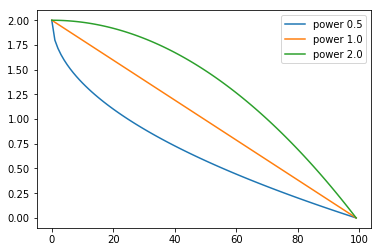

In [ ]:
a = torch.arange(0, 100)
p = torch.linspace(0.,1,100)

pows = [0.5,1.,2.]
for e in pows:
    f = sched_poly(2, 0, e)
    plt.plot(a, [f(o) for o in p], label=f'power {e}')
plt.legend();

In [ ]:
#export
def combine_scheds(pcts, scheds):
    "Combine `scheds` to make one function using them according to `pcts`"
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

## ParamScheduler -

In [ ]:
class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs):
        self.pname,self.sched_funcs = pname,L(sched_funcs)

    def begin_batch(self): 
        if not self.training: return
        fs = self.sched_funcs
        if len(fs)==1: fs = fs*len(self.opt.param_groups)
        pos = self.n_epochs/self.epochs
        for f,h in zip(fs,self.opt.hypers): h[self.pname] = f(pos)